# Timing

In order to analyze ecephys passive viewing data, you need to be able to answer questions of the form:
```
At time t, what stimulus was being displayed to the subject?
```
Where `t` is any time of interest, such as a spiking event.

## Background

To draw stimuli on the monitor, we use an in-house Python package called [camstim](http://aibspi/braintv/camstim). camstim uses [psychopy](https://www.psychopy.org/index.html) to display stimuli, while listening to and recording events from a National Instruments Digital Acquisition system (DAQ). Under the hood, psychopy itself relies on [opengl](https://www.opengl.org/) for communication with the GPU. camstim is driven by a stimulus script. These are [stored here](http://stash.corp.alleninstitute.org/users/joshs/repos/ecephys_stimulus_scripts/browse). Our extracellular electrophysiology (ecephys) sessions have been collected using camstim version 0.2.9.

###### event loop

camstim repeatedly executes [the following loop](http://aibspi/braintv/camstim/blob/0.2.9/camstim/sweepstim.py#L1044):
- iteratively update contained stimuli. This:
  - potentially alters stimulus parameters, e.g. changing the orientation of a static grating
  - draws the stimulus using psychopy. The prepared frame is written to the back opengl buffer.
- iteratively update contained "items". These can be a bit eclectic but might involve sampling the orientation of the running wheel, for instance.
- on the DAQ, set the "vsync" line (which might be called "stim_vsync" or similar) high.
- call [flip](http://aibspi/braintv/camstim/blob/0.2.9/camstim/window.py#L637) on the session's shared psychopy window. This swaps the front and back buffers, so that the GPU sends the new stimulus frame to the monitor.
- on the DAQ, set the vsync line low.

Based on this loop, the falling edges on the vsync line are the closest recorded timestamps to the display time of the stimulus. However, they are not the times at which the stimuli are displayed! This is because:
1. it takes time for the monitor to receive and display the frame from the GPU
2. the monitor displays frames on its own, ~60hz clock.

###### photodiode

To record the actual times at which frames are displayed to the subject, a patch of the frame (the "sync square") is reserved from the stimuli. The sync square is flipped between black and white every 60 frames (this is implemented as a camstim stimulus). To record these flips, a photodiode is attached to the monitor, placed over the sync square. When the sync square transitions, the photidiode writes a rising or falling edge to a line on the DAQ. Since we know the time at which the `60 * i`th frame was flipped onto the front buffer as well as the time of the `i`th photodiode edge, we can calculate a transform between the vsync falling edge times and photodiode times, then apply that transform to obtain the time at which an arbitrary frame was displayed.

## example: 2p ophys

Here is an example of stimulus synchronization using an arbitrarily chosen 2P (optical physiology) passive viewing experiment.

In [1]:
# Python import boilerplate

from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np

from allensdk.brain_observatory.sync_dataset import Dataset

In [2]:
# set up some paths

ophys_dir = Path("/allen/programs/braintv/production/neuralcoding/prod5/specimen_491604967/ophys_experiment_496908818/")
ophys_sync_path = ophys_dir / Path("496908818_222181_20160120_sync.h5")

In [3]:
# load the recorded edge times

ophys_sync = Dataset(ophys_sync_path)
ophys_vs = ophys_sync.get_edges(keys=("stim_vsync",), kind="falling")
ophys_pd = ophys_sync.get_edges(keys=("stim_photodiode",), kind="all", units="seconds")
ophys_pd_falling = ophys_sync.get_edges(keys=("stim_photodiode",), kind="falling")
ophys_pd_rising = ophys_sync.get_edges(keys=("stim_photodiode",), kind="rising")

To start, we'll plot the first few photodiode timestamps:

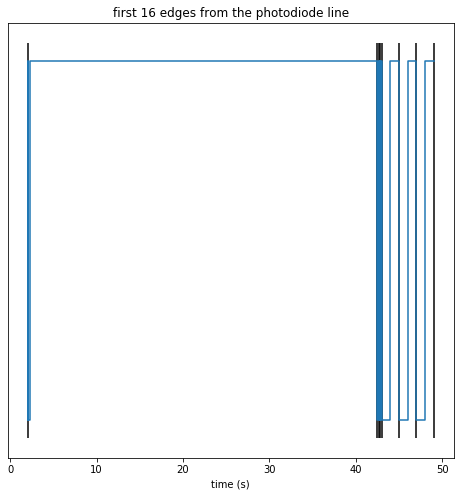

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))

num_pd_samples = 8
step_vals = np.vstack([np.zeros(num_pd_samples), np.ones(num_pd_samples)]).T.flatten()
ax.step(ophys_pd[:num_pd_samples*2], step_vals)

# validate that the edge directions are oriented correctly
ax.vlines(ophys_pd_falling[:num_pd_samples], ymin=-0.05, ymax=1.05, color="black")

ax.tick_params("y", left=False, labelleft=False)
ax.set_xlabel("time (s)")
ax.set_title(f"first {num_pd_samples * 2} edges from the photodiode line")

plt.show()

This shows three distinct modes:
1. a pre-experiment state interrupted by a spike when the window is initialized
2. several fast "sentinel" pulses at the start of the experiment
3. a regular 2hz square wave

There is also a set of sentinel pulses (and a spike) at the end of the session. We can plot the the photodiode interval lengths to get a better sense of what is going on:

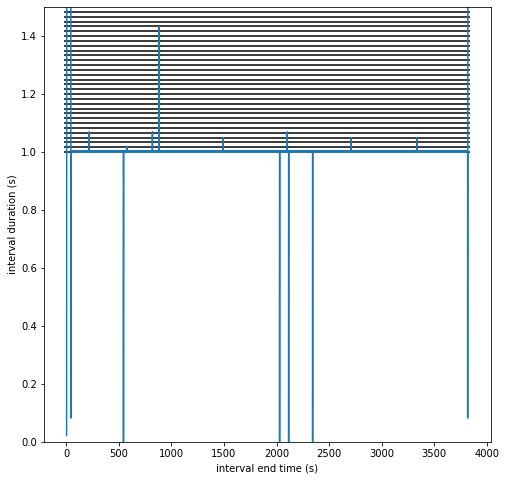

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))

pd_diff = np.diff(ophys_pd)
med_diff = np.median(pd_diff)
frame_dur_exp = 1 / 60

ax.plot(ophys_pd[1:], pd_diff)

for ii in range(30):
    ax.hlines([med_diff + frame_dur_exp * ii], xmin=ophys_pd[1]-20, xmax=ophys_pd[-1]+20)

plt.ylim(top=1.5, bottom=0)

ax.set_ylabel("interval duration (s)")
ax.set_xlabel("interval end time (s)")

plt.show()

Black lines are drawn at 1s + n frames. If one or more frames are dropped, we ought to see these as photodiode intervals lying on (or a couple ms from - the photodiode intervals vary in general by ~2.5 ms depending on whether the transition is black -> white or white -> black) these black lines.

Overall, there are a few standouts:
1. at the start and end of the session, there are fast sentinel flashes, window on/off events, and long periods where the sync square does not change.
2. There are dropped frames scattered throughout the session. Often, they clump into a single photodiode interval.
3. There are a few cases where the interval is ~0. This probably reflects a brief oscillation around the transition time.
4. around 882 seconds in, about 26 frames worth of time was dropped.

We only care about frame-driven sync square changes, so we ought to drop the pre- and post-session flashes. We can also safely remove the periodic ultra-short flash groups.

In [6]:
first_vs = ophys_vs[0]
last_vs = ophys_vs[-1]

ophys_pd = ophys_pd[np.logical_and(ophys_pd > first_vs, ophys_pd < last_vs)]

short_intervals = np.where(np.diff(ophys_pd) < frame_dur_exp)
ophys_pd = np.delete(ophys_pd, short_intervals)

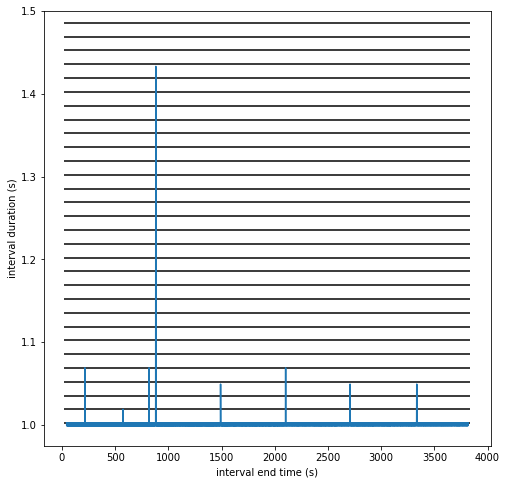

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

pd_diff = np.diff(ophys_pd)
med_diff = np.median(pd_diff)
frame_dur_exp = 1 / 60

ax.plot(ophys_pd[1:], pd_diff)

for ii in range(30):
    ax.hlines([med_diff + frame_dur_exp * ii], xmin=ophys_pd[1]-20, xmax=ophys_pd[-1]+20)

plt.ylim(top=1.5)

ax.set_ylabel("interval duration (s)")
ax.set_xlabel("interval end time (s)")

plt.show()

So now we're left with dropped frames. We also have a sensible number of photodiode edges:

In [8]:
print(ophys_pd.size)
print(ophys_vs[::60].size)

3772
3772


To investigate the dropped frames, we'll look at the vsync intervals:

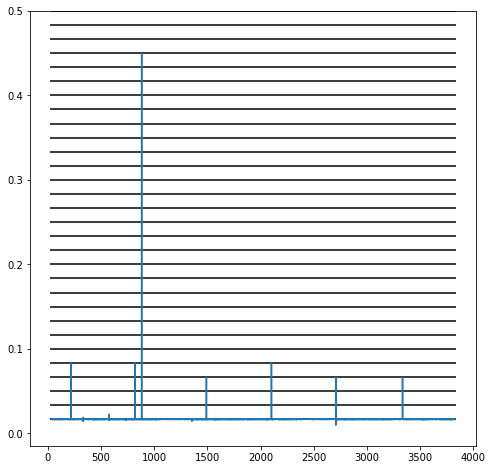

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))

vs_diff = np.diff(ophys_vs)
ax.plot(ophys_vs[1:], vs_diff)

for ii in range(1, 31):
    ax.hlines([frame_dur_exp * ii], xmin=ophys_pd[1]-20, xmax=ophys_pd[-1]+20)

plt.ylim(top=0.5)
    
plt.show()

These look almost exactly the same as the photodiode delay values, suggesting that we indeed have some bursts of dropped frames. Some things to note:
- The vsync intervals are for the most part very close to 1/60 seconds. Sometimes they dip a bit above or below, and this gets rectified out by the monitor's clock.
- Unlike the other bursts of dropped frames, the one at around ~520 seconds seems to have taken less than one full frame. Since this was reflected in a photodiode delay of ~1/60 seconds, our best guess is that the frame was just late enough to miss the monitor's refresh.

Now we can go ahead an calculate the monitor delay for this session:

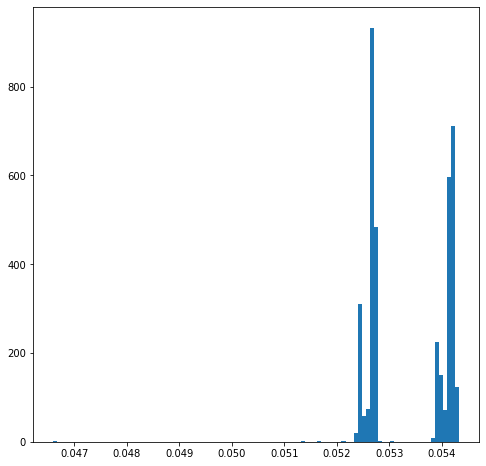

In [10]:
monitor_delays = ophys_pd - ophys_vs[::60]

fig, ax = plt.subplots(figsize=(8, 8))
plt.hist(monitor_delays, bins=100)
plt.show()

## Example: extracellular ephys

In [11]:
ecephys_dir = Path("/allen/programs/braintv/production/neuralcoding/prod56/specimen_719828690/ecephys_session_754312389")
ecephys_sync_path = ecephys_dir / Path("754312389_404570_20180917.sync")

ecephys_sync = Dataset(ecephys_sync_path)

ecephys_pd = ecephys_sync.get_edges(keys=["stim_photodiode"], kind="all", units="seconds")
ecephys_vs = ecephys_sync.get_edges(keys=["stim_vsync"], kind="falling", units="seconds")

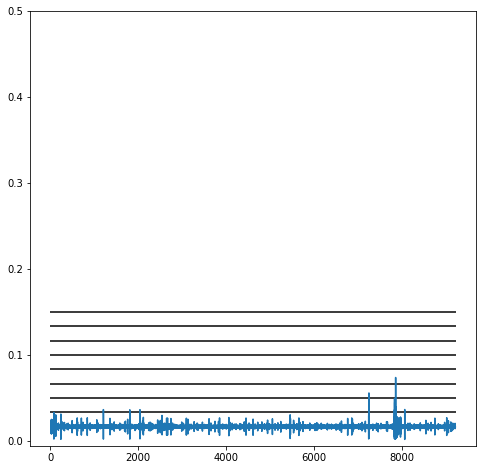

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

plt.plot(ecephys_vs[1:], np.diff(ecephys_vs))

for ii in range(1, 10):
    ax.hlines([frame_dur_exp * ii], xmin=ecephys_vs[1]-20, xmax=ecephys_vs[-1]+20)

plt.ylim(top=0.5)
    
plt.show()

<IPython.core.display.Javascript object>


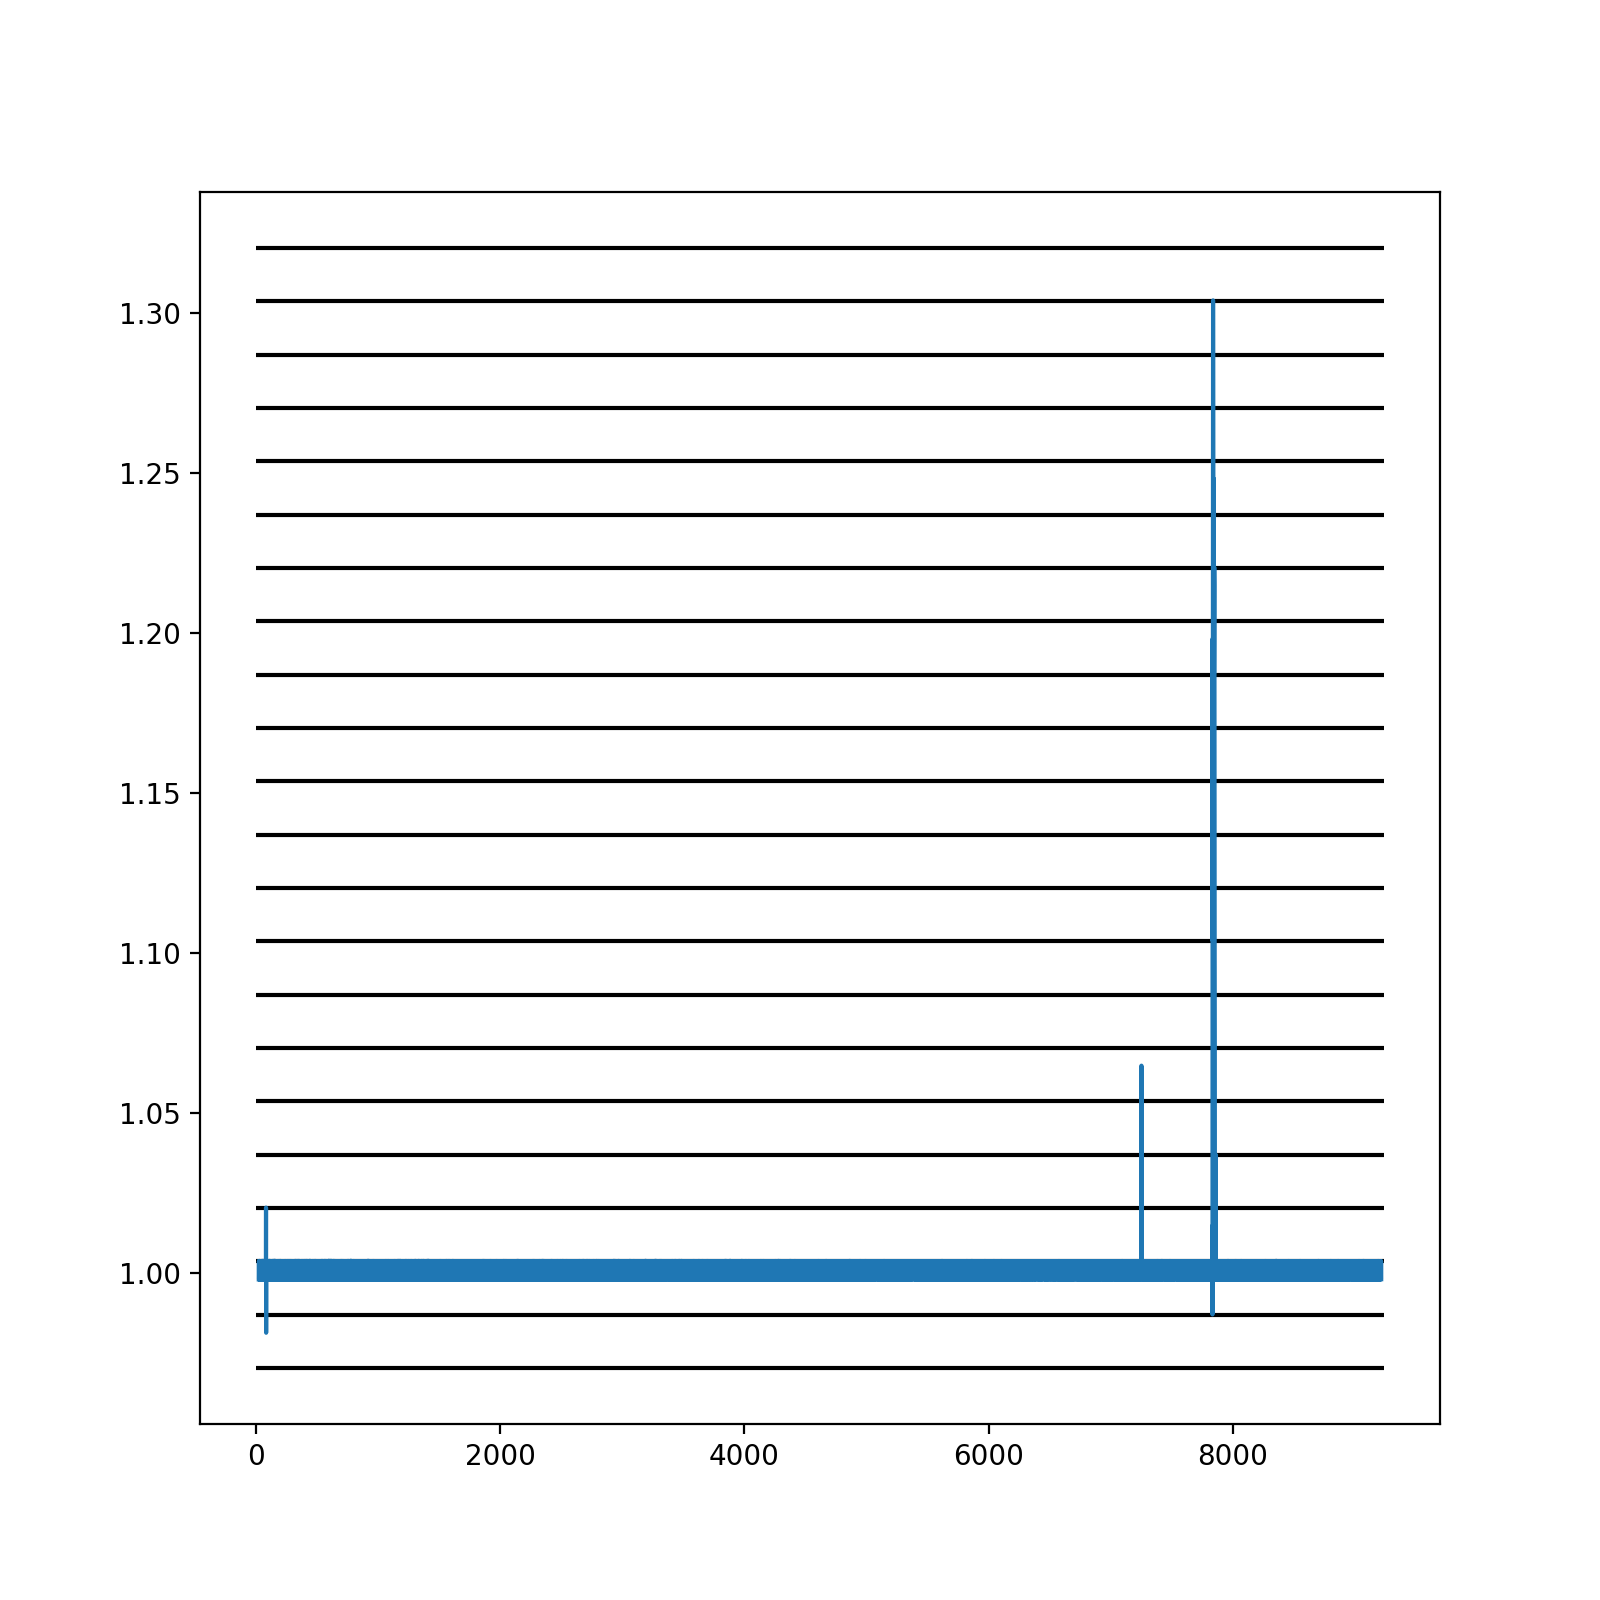

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))

ecephys_pd_trim = ecephys_pd[np.logical_and(ecephys_pd > ecephys_vs[0], ecephys_pd < ecephys_vs[-1])]
ecephys_pd_trim_diff = np.diff(ecephys_pd_trim)
ecephys_pd_trim_diff_med = np.median(ecephys_pd_trim_diff)

plt.plot(ecephys_pd_trim[1:], ecephys_pd_trim_diff)

for ii in range(-2, 20):
    ax.hlines([ecephys_pd_trim_diff_med + frame_dur_exp * ii], xmin=ecephys_pd_trim[1]-20, xmax=ecephys_pd_trim[-1]+20)

plt.show()

Two things jump out:
- the vsync falling edge times are noisy. There are numerous intervals that are not close to 1/60 seconds.
- vsync intervals may approach the dropped frame threshold, with no dropped frame visible in the photodiode intervals.
- there are short photodiode intervals. This does not fit with our understanding of dropped frames, where a dropped frame simply delays the presentation of (all future) stimulus frames.

The latter issue is particularly odd. The sync square is updated or not on each frame according to [this function](http://aibspi/braintv/camstim/blob/0.2.9/camstim/synchro.py#L103), which chooses whether to update the color based on simple modular arithmetic. What could be going on?

One possibility is that the call to `draw()` operates asynchronously. If the updated sync square is still being drawn when the window is flipped, we would expect the underlying stimulus to show through, which could result in a long photodiode interval immediately followed by a short one. This could explain the cases we see in this session.

However, other sessions might be more complicated:

In [15]:
messy_ecephys_sync_path = Path(
    "/allen/programs/braintv/production/neuralcoding/prod56/specimen_718643567/"
    "ecephys_session_737581020/737581020_404568_20180816.sync"
)

In [19]:
messy_sync = Dataset(messy_ecephys_sync_path)
messy_pd = messy_sync.get_edges(keys=["photodiode"], kind="all", units="seconds")
messy_vs = messy_sync.get_edges(keys=["frames"], kind="falling", units="seconds")

<IPython.core.display.Javascript object>


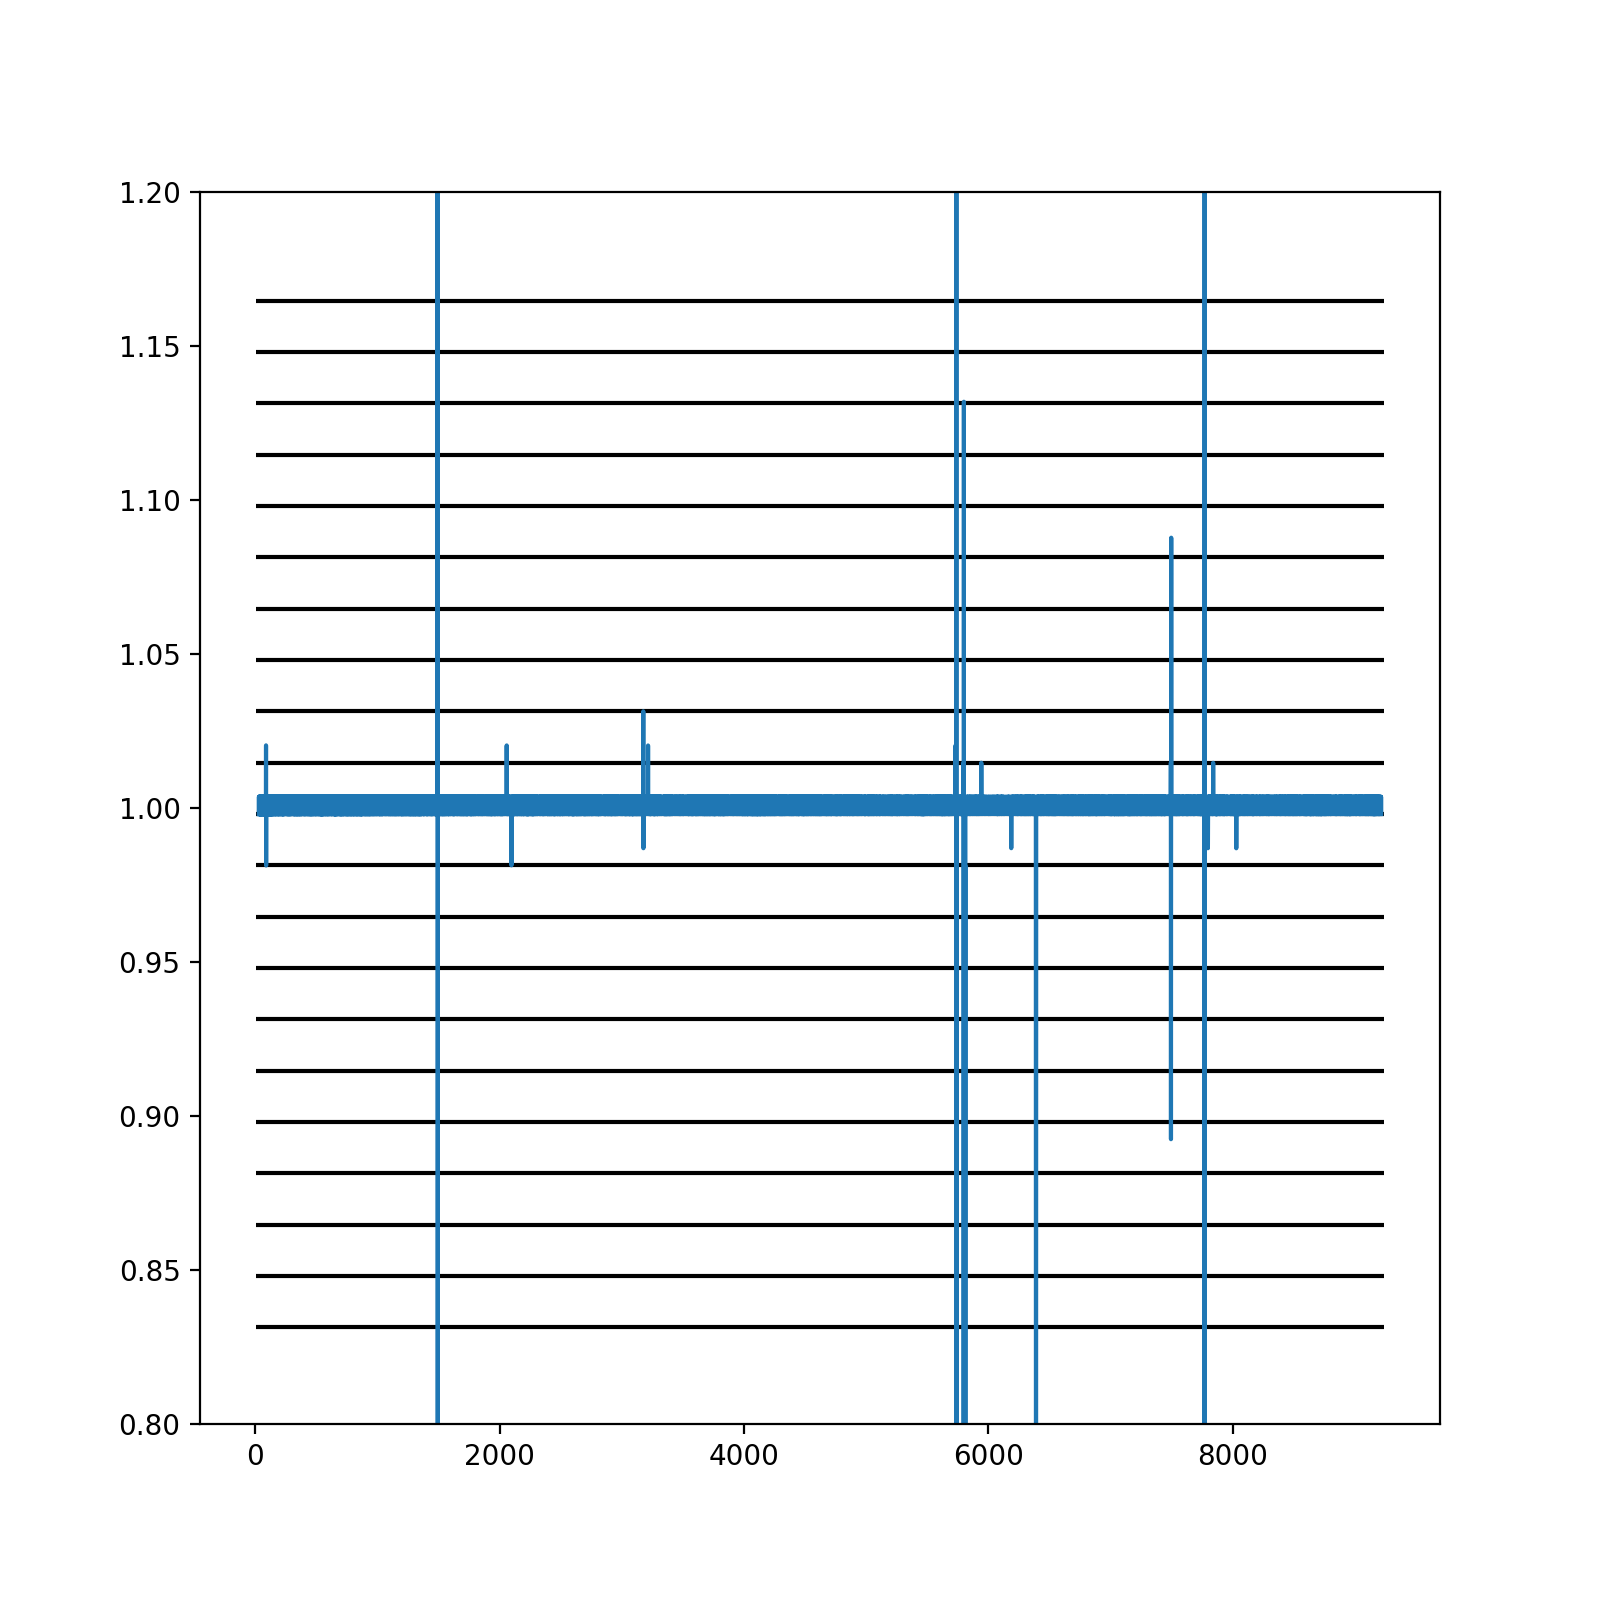

In [23]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(8, 8))

messy_pd_trim = messy_pd[np.logical_and(messy_pd > messy_vs[0], messy_pd < messy_vs[-1])]
messy_pd_trim_diff = np.diff(messy_pd_trim)
messy_pd_trim_diff_med = np.median(messy_pd_trim_diff)

plt.plot(messy_pd_trim[1:], messy_pd_trim_diff)

for ii in range(-10, 11):
    ax.hlines(
        [messy_pd_trim_diff_med + frame_dur_exp * ii], 
        xmin=messy_pd_trim[1] - 20, 
        xmax=messy_pd_trim[-1] + 20
    )

plt.ylim([0.8, 1.2])
    
plt.show()

This session shows:
- long -> short intervals
- long -> normal ... -> short
- apparently isolated long and short intervals
- intervals of extreme length

We don't have a good explanation for these.

### Collection phases

Ecephys sessions were collected under multiple sync-relevant conditions:
- in early sessions (and maybe some later ones?) experimenters might have run other software on the rig. This causes noisy vsyncs.
- up till 2019, the rigs were running antivirus softare. Data acquired after that has less noisy (but still not clean compared to ophys) vsync intervals.

We do not know whether the short photodiode intervals occur evenly across these conditions.